In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 716.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 6.0 MB/s eta 0:00:00


In [2]:
import os
import gc
import glob
import yaml
import shutil
from IPython.display import clear_output

import wandb
from wandb.integration.ultralytics import add_wandb_callback
from ultralytics import YOLO
from kaggle_secrets import UserSecretsClient

import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from datetime import datetime

wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


In [3]:
ROOT = '/kaggle/working/data'
IMAGES_ROOT = '/kaggle/working/data/images'
LABELS_ROOT = '/kaggle/working/data/labels'
PREDICTIONS_ROOT = '/kaggle/working/predictions'
RAW_DATA_ROOT = '/kaggle/input/math-formula-detection/ICDAR2021'

IMAGE_SIZE = (2048, 1447)
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.75
FONT_THICKNESS = 2
BORDER_THICKNESS = 2

In [4]:
def plot_image_with_bbox(image, bboxes, scores, color, ax):
    bboxes = bboxes.astype(int)
    image = image.copy()
    
    for i, bbox in enumerate(bboxes):
        label = f"Formula: {scores[i]:.3f}"
        label_y = bbox[1] - 10 if bbox[1] - 10 > 10 else bbox[1] + 10
        (label_w, label_h), label_b = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICKNESS)
        
        # Bounding box
        cv2.rectangle(
            img=image,
            pt1=(bbox[0], bbox[1]), 
            pt2=(bbox[2], bbox[3]), 
            color=color, thickness=BORDER_THICKNESS
        )
        # Text background
        cv2.rectangle(
            img=image,
            pt1=(bbox[0] - BORDER_THICKNESS + 1, bbox[1]), 
            pt2=(bbox[0] + label_w, label_y - label_h), 
            color=color, thickness=-1
        )
        # Text
        cv2.putText(
            img=image, text=label, 
            org=(bbox[0], label_y + BORDER_THICKNESS + 1), 
            fontFace=FONT, fontScale=FONT_SCALE, 
            color=(255, 255, 255), thickness=FONT_THICKNESS
        )
    
    ax.imshow(image)
    ax.axis("off")

In [5]:
a = np.array(sorted(map(lambda x: x[:-4], os.listdir(os.path.join(RAW_DATA_ROOT, 'images', 'train')))))
b = np.array(sorted(map(lambda x: x[:-4], os.listdir(os.path.join(RAW_DATA_ROOT, 'labels', 'train')))))

(a == b).all()

True

In [6]:
image1 = cv2.imread("/kaggle/input/math-formula-detection/ICDAR2021/images/train/0001101-page06.jpg")
image1.shape

(2048, 1447, 3)

In [7]:
!rm -rf '/kaggle/working/data'

!mkdir '/kaggle/working/data'
!mkdir '/kaggle/working/data/images'
!mkdir '/kaggle/working/data/labels'

!mkdir '/kaggle/working/data/images/train'
!mkdir '/kaggle/working/data/images/test'
!mkdir '/kaggle/working/data/images/validation'

!mkdir '/kaggle/working/data/labels/train'
!mkdir '/kaggle/working/data/labels/test'
!mkdir '/kaggle/working/data/labels/validation'

In [8]:
for subset in ['train', 'test', 'validation']:
    # Retrieving all images and labels for each subset of the data
    images = sorted(glob.glob(os.path.join(RAW_DATA_ROOT, 'images', subset, '*.jpg')))
    labels = sorted(glob.glob(os.path.join(RAW_DATA_ROOT, 'labels', subset, '*.txt')))
    
    for image, label in tqdm(zip(images, labels), total=len(images), desc=f'Copying {subset} data'):
        # Image copying
        shutil.copy(image, os.path.join(IMAGES_ROOT, subset))
        
        # Label copying (have to process bounding box coordinates 
        # since they are not yet normalized)
        label_name = label.split("/")[-1]
        with open(label, 'r') as lf:
            label_lines = map(lambda l: l.split(), lf.readlines())
            
        for line in label_lines:
            line = np.array(line, dtype=np.float16)
            
            x_min, y_min = line[[1, 2]]
            x_max, y_max = line[[3, 4]]
            
            x_center = str((x_min + x_max) / (2 * IMAGE_SIZE[1]))
            y_center = str((y_min + y_max) / (2 * IMAGE_SIZE[0]))
            width = str((x_max - x_min) / IMAGE_SIZE[1])
            height = str((y_max - y_min) / IMAGE_SIZE[0])
                
            with open(os.path.join(LABELS_ROOT, subset, label_name), "a+") as lf:
                lf.write(str(int(line[0])) + " ")
                lf.write(" ".join([x_center, y_center, width, height]))
                lf.write("\n")

Copying train data:   0%|          | 0/5171 [00:00<?, ?it/s]

Copying test data:   0%|          | 0/2144 [00:00<?, ?it/s]

Copying validation data:   0%|          | 0/957 [00:00<?, ?it/s]

In [9]:
with (
    open("/kaggle/working/data/labels/train/0001101-page06.txt", "r") as lf1,
    open("/kaggle/input/math-formula-detection/ICDAR2021/labels/train/0001101-page06.txt", "r") as lf2
):
    label1 = list(map(lambda x: x.strip().split(" "), lf1.readlines()))
    label2 = list(map(lambda x: x.strip().split("\t"), lf2.readlines()))

label1 = np.array(label1, dtype=np.float16)
label2 = np.array(label2, dtype=np.float16)

label1[:, [1, 3]] *= IMAGE_SIZE[1]
label1[:, [2, 4]] *= IMAGE_SIZE[0]

label1[:, 1] -= label1[:, 3] // 2
label1[:, 2] -= label1[:, 4] // 2

label1[:, 3] += label1[:, 1]
label1[:, 4] += label1[:, 2]
label1[:, 0] = 1.0

label1 = label1.astype(int)

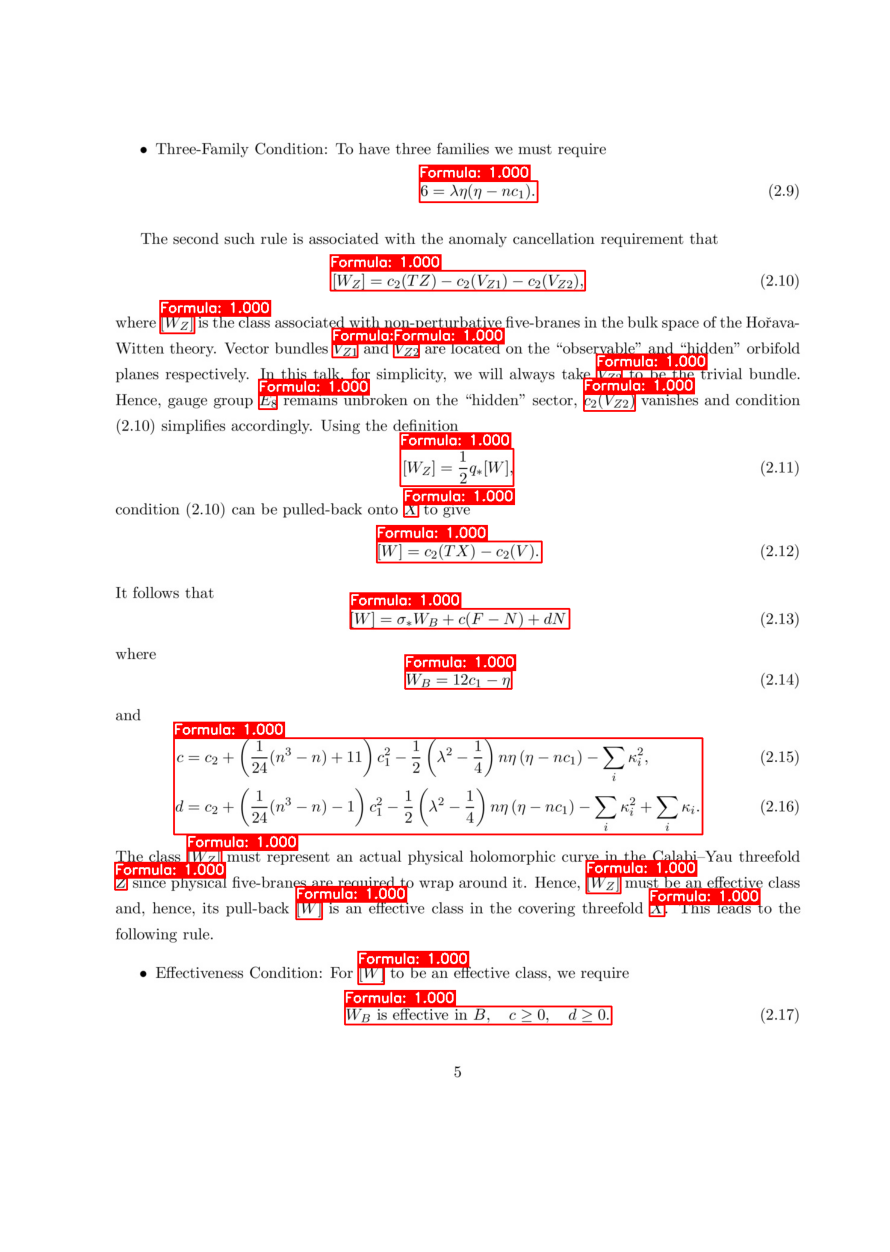

In [10]:
plt.figure(figsize=(16, 16))

plot_image_with_bbox(
    image=image1, 
    bboxes=label1[:, 1:],
    scores=label1[:, 0],
    color=(255, 0, 0),
    ax=plt
)

In [11]:
data_config = {
    'path': ROOT,
    'train': os.path.join(IMAGES_ROOT, 'train'),
    'val': os.path.join(IMAGES_ROOT, 'validation'),
    'nc': 1,
    'names': {0: "math formula"}
}
             
with open('/kaggle/working/data.yaml', 'w+') as outfile:
    yaml.dump(data_config, outfile, default_flow_style=False)

In [12]:
torch.cuda.empty_cache()
gc.collect()
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [13]:
user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_secret)
wandb.init(project="Math-formula-detection", job_type="training", name=datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yadroff (yadroff_edu). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240418_211330-xtkgpmaz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run 2024_04_18_21_13_30
wandb: ⭐️ View project at https://wandb.ai/yadroff_edu/Math-formula-detection
wandb: 🚀 View run at https://wandb.ai/yadroff_edu/Math-formula-detection/runs/xtkgpmaz/workspace


In [14]:
model = YOLO('yolov8m.pt')
add_wandb_callback(model, enable_model_checkpointing=True)
clear_output()

In [15]:
INPUT_SIZE = 640
N_EPOCHS = 100
PATIENCE = 5
BATCH_SIZE = 64
CACHE_DATA = True
DEVICES = [0, 1]

In [16]:
model.train(
    data="/kaggle/working/data.yaml", 
    epochs=N_EPOCHS, 
    patience=PATIENCE, 
    imgsz=INPUT_SIZE,
    batch=BATCH_SIZE, 
    cache=CACHE_DATA,
    device=DEVICES,
    project='Math-formula-detection',
)

Ultralytics YOLOv8.2.1 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                     CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=5, batch=64, imgsz=640, save=True, save_period=-1, cache=True, device=[0, 1], workers=8, project=Math-formula-detection, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]
2024-04-18 21:13:50,910	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-18 21:13:51,684	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-18 21:13:53.867579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 21:13:53.867701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 21:13:54.002805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

2024-04-18 21:14:10.979257: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 21:14:10.979317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 21:14:10.980927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir Math-formula-detection/train', view at http://localhost:6006/


wandb: Currently logged in as: yadroff (yadroff_edu). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240418_211414-viao23is
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train
wandb: ⭐️ View project at https://wandb.ai/yadroff_edu/Math-formula-detection
wandb: 🚀 View run at https://wandb.ai/yadroff_edu/Math-formula-detection/runs/viao23is/workspace


Overriding model.yaml nc=80 with nc=1
Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 76.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/labels/train... 4649 images, 522 backgrounds, 0 corrupt: 100%|██████████| 5171/5171 [00:04<00:00, 1110.07it/s]


train: New cache created: /kaggle/working/data/labels/train.cache


train: Caching images (4.2GB RAM): 100%|██████████| 5171/5171 [00:58<00:00, 88.99it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/data/labels/validation... 856 images, 101 backgrounds, 0 corrupt: 100%|██████████| 957/957 [00:00<00:00, 1296.86it/s]


val: New cache created: /kaggle/working/data/labels/validation.cache


val: Caching images (0.8GB RAM): 100%|██████████| 957/957 [00:17<00:00, 55.10it/s]


Plotting labels to Math-formula-detection/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Math-formula-detection/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.9G       1.92      1.751      1.415        843        640: 100%|██████████| 81/81 [02:10<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


                   all        957      18370      0.624      0.538       0.61      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.1G      1.176     0.8587     0.9974        776        640: 100%|██████████| 81/81 [01:27<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


                   all        957      18370       0.53      0.523      0.511      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.9G      1.142     0.7965     0.9851        888        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.719      0.661      0.728      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      14.5G      1.105     0.7535     0.9763        703        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.724      0.636      0.715      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.8G      1.083     0.7302     0.9638        817        640: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


                   all        957      18370      0.752      0.715      0.777      0.492


  0%|          | 0/81 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.6G      1.045      0.687     0.9475        772        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370      0.814      0.731      0.806      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      14.4G      0.995      0.653     0.9356        791        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370      0.773      0.715      0.778      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100        15G     0.9787     0.6353     0.9277        707        640: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370      0.761       0.73      0.765      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      15.1G     0.9549     0.6204     0.9174        883        640: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.804      0.704      0.792      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.9G     0.9386     0.6073     0.9133        590        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


                   all        957      18370      0.639        0.6      0.634      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.8G     0.9238     0.5916     0.9017        604        640: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


                   all        957      18370      0.829      0.775      0.851      0.556


  0%|          | 0/81 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      15.1G     0.8997     0.5754     0.8968        677        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


                   all        957      18370      0.834      0.759      0.843      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.5G     0.8785     0.5582     0.8938        769        640: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.834      0.747      0.833      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.4G     0.8838     0.5565     0.8928        832        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.818      0.749      0.829      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.8G     0.8568     0.5404     0.8803        980        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370        0.6      0.601      0.599      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.2G     0.8467     0.5347     0.8765        763        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.851      0.771      0.846      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.2G     0.8324      0.522     0.8731        627        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


                   all        957      18370      0.842      0.769      0.854      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.4G      0.825     0.5156     0.8727        890        640: 100%|██████████| 81/81 [01:26<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.848      0.745       0.84       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      15.4G     0.8183     0.5118     0.8744       1018        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370      0.672      0.541      0.613       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.7G     0.8001     0.5031     0.8684        773        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370       0.86       0.76      0.851      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      15.2G     0.7865     0.4902     0.8663        823        640: 100%|██████████| 81/81 [01:27<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370      0.859      0.783      0.866      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100        15G     0.7811     0.4885      0.865        958        640: 100%|██████████| 81/81 [01:27<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


                   all        957      18370       0.85      0.743      0.842      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.7G     0.7687     0.4809     0.8613        901        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


                   all        957      18370      0.866      0.777      0.868      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.5G     0.7521     0.4693     0.8588        966        640: 100%|██████████| 81/81 [01:27<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


                   all        957      18370      0.637      0.613      0.635       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      15.2G     0.7527     0.4694     0.8593        635        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


                   all        957      18370      0.864      0.781      0.871      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      15.4G     0.7365     0.4606     0.8582        715        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


                   all        957      18370      0.854      0.771      0.856      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100        14G     0.7315     0.4554     0.8568        894        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


                   all        957      18370      0.871      0.786      0.876      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      15.2G     0.7033     0.4353     0.8497        807        640: 100%|██████████| 81/81 [01:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


                   all        957      18370      0.876      0.783      0.871      0.593
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 23, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

28 epochs completed in 0.792 hours.
Optimizer stripped from Math-formula-detection/train/weights/last.pt, 52.0MB
Optimizer stripped from Math-formula-detection/train/weights/best.pt, 52.0MB

Validating Math-formula-detection/train/weights/best.pt...
Ultralytics YOLOv8.2.1 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                     CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]


                   all        957      18370      0.866      0.777      0.868      0.598
Speed: 0.1ms preprocess, 7.4ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to Math-formula-detection/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁▅██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅
wandb:                  lr/pg1 ▁▅██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅
wandb:                  lr/pg2 ▁▅██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅
wandb:        metrics/mAP50(B) ▃▁▅▅▆▇▆▆▆▃█▇▇▇▃▇█▇▃██▇█▃████
wandb:     metrics/mAP50-95(B) ▃▁▅▅▆▆▆▅▆▃▇▇▇▇▃▇█▇▂▇█▇█▄████
wandb:    metrics/precision(B) ▃▁▅▅▆▇▆▆▇▃▇▇▇▇▂█▇█▄████▃████
wandb:       metrics/recall(B) ▁▁▅▄▆▇▆▆▆▃█▇▇▇▃██▇▁▇█▇█▃████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            val/box_loss ▅█▄▄▃▃▃▄▄▆▂▁▂▂▅▃▁▂█▂▁▂▁▅▁▁▁▁
wandb:            val/cls_loss ▅█▄▄▃▂▃▄▃▅▂▂▂▂▆▂▁▂█▁▁▁▁▇▁▁▁▁
wandb:            val/dfl_loss ▅█▄▃▃▃▂▅▃▇▂▂▂▂▆▂▁▂█▂▁▂▁▆▂▁▁▁
wandb:

In [17]:
best_weights = "/kaggle/working/Math-formula-detection/train/weights/best.pt"
best_model = YOLO(best_weights) 
metrics = best_model.val() 

Ultralytics YOLOv8.2.1 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/data/labels/validation.cache... 856 images, 101 backgrounds, 0 corrupt: 100%|██████████| 957/957 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:32<00:00,  1.86it/s]


                   all        957      18370      0.865      0.778      0.868      0.604
Speed: 0.3ms preprocess, 18.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/val


In [18]:
print(f"Mean Average Precision @.5:.95: {metrics.box.map}")    
print(f"Mean Average Precision @.5:     {metrics.box.map50}") 
print(f"Mean Average Precision @.7:     {metrics.box.map75}")

Mean Average Precision @.5:.95: 0.6038720201223164
Mean Average Precision @.5:     0.8684752179184644
Mean Average Precision @.7:     0.6912942644848712


In [19]:
with torch.no_grad():
    predictions = best_model.predict(
        source="/kaggle/input/math-formula-detection/ICDAR2021/images/test",
        conf=0.05,
        iou=0.75,
        stream=True
    )

In [20]:
!rm -rf "/kaggle/working/predictions"
!mkdir "/kaggle/working/predictions"

In [21]:
test_images = []

for prediction in predictions:
    if len(prediction.boxes.xyxy):
        name = prediction.path.split("/")[-1].split(".")[0]
        boxes = prediction.boxes.xyxy.cpu().numpy()
        scores = prediction.boxes.conf.cpu().numpy()
        
        test_images += [name]
        label_path = os.path.join(PREDICTIONS_ROOT, name + ".txt")
        
        with open(label_path, "w+") as f:
            for score, box in zip(scores, boxes):
                text = f"{score:0.4f} {' '.join(box.astype(str))}"
                f.write(text)
                f.write("\n")

clear_output()

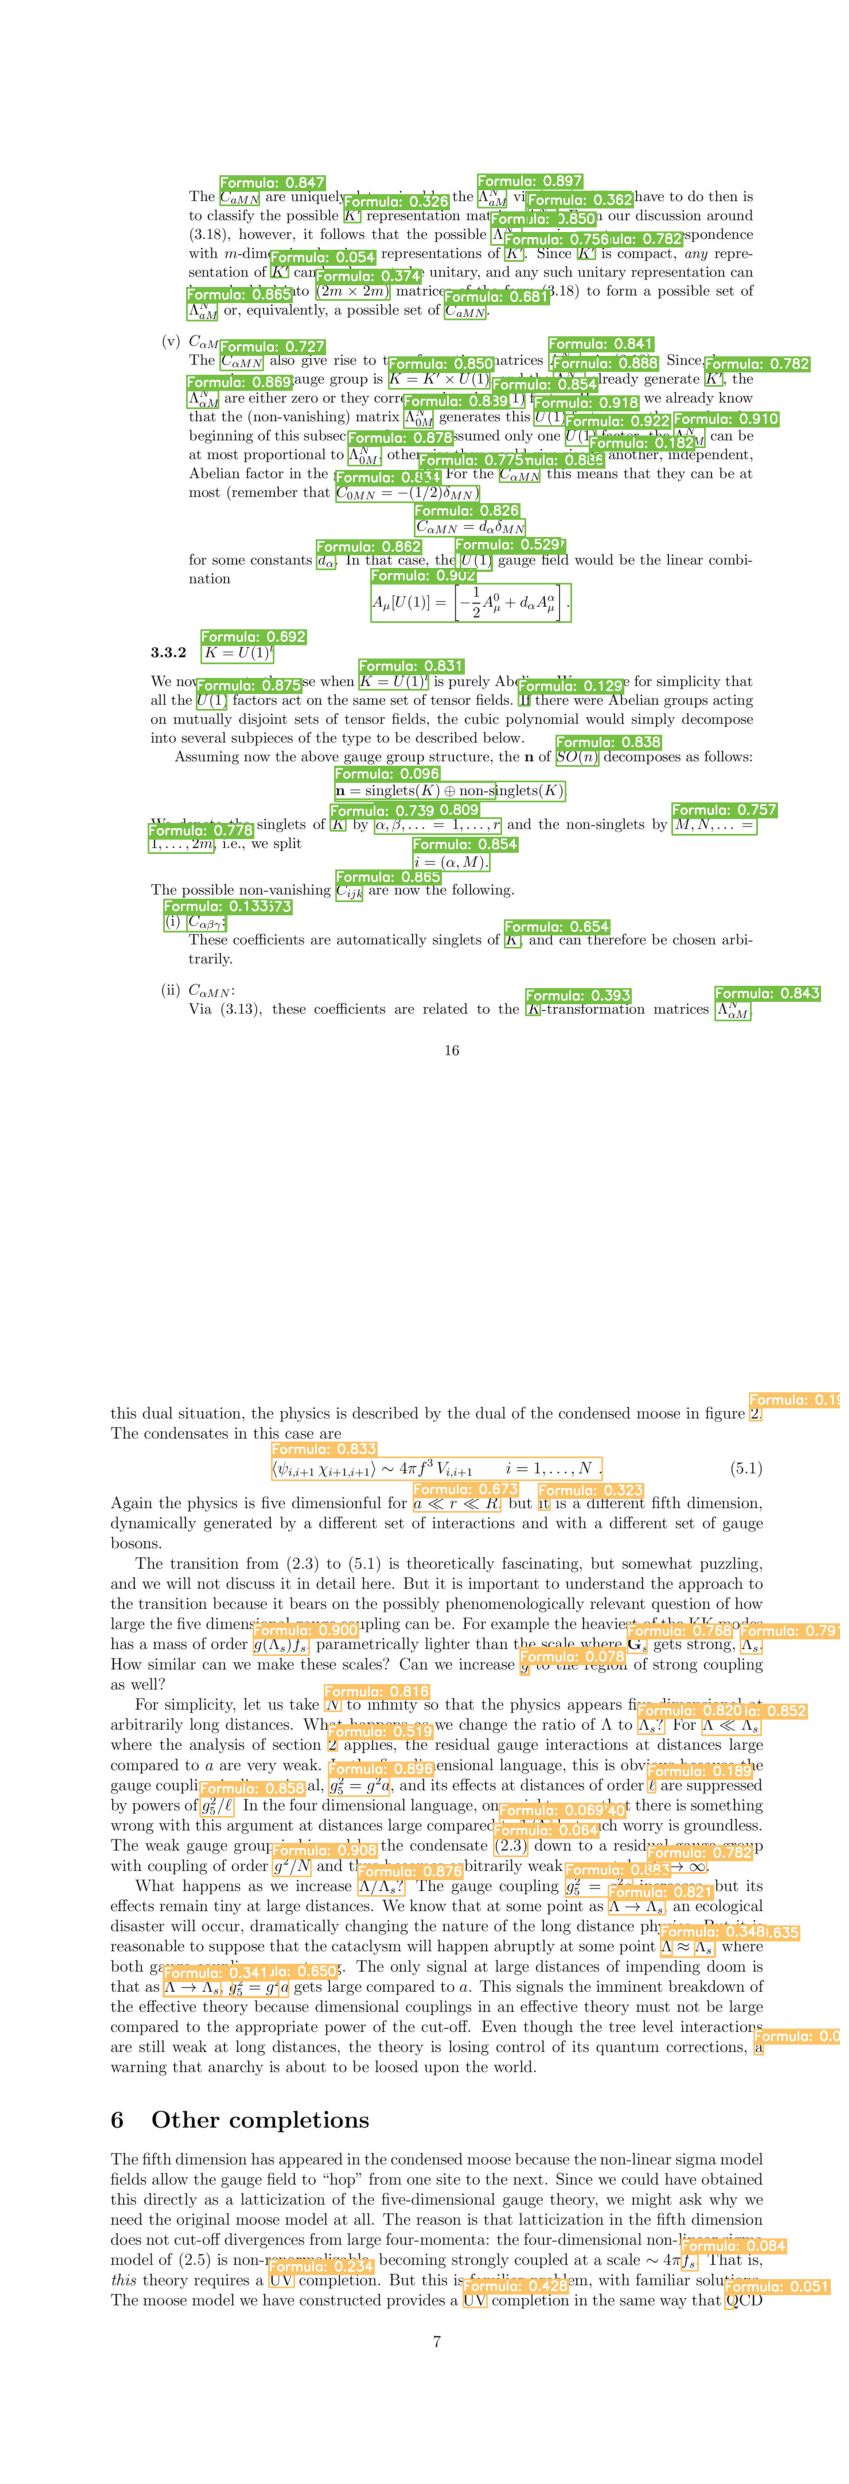

In [22]:
NUM_IMAGES = 2

fig, axs = plt.subplots(NUM_IMAGES, 1, figsize=(32, 32))
axs = axs.flatten()

plt.subplots_adjust(wspace=0.1, hspace=0.1)

image_names = np.random.choice(test_images, NUM_IMAGES)

for i, image_name in enumerate(image_names):
    image_path = os.path.join(
        '/kaggle/input/math-formula-detection/ICDAR2021/images/test', 
        image_name + ".jpg"
    )
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    label_path = os.path.join(PREDICTIONS_ROOT, image_name + ".txt")
    label = pd.read_csv(label_path, sep=" ", header=None).values
    
    scores = label[:, 0]
    bboxes = label[:, 1:]
    color = np.random.randint(0, 255, (3,)).tolist()
    
    plot_image_with_bbox(image, bboxes, scores, color, axs[i])

In [23]:
wandb.finish()

wandb:                                                                                
wandb: 🚀 View run 2024_04_18_21_13_30 at: https://wandb.ai/yadroff_edu/Math-formula-detection/runs/xtkgpmaz/workspace
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240418_211330-xtkgpmaz/logs
